In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
import random
import numpy as np
import pandas as pd
from pandas import DataFrame
import cPickle as pickle
import math
import copy

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
with open('../data/state_features.txt') as f:
    state_features = f.read().split()
print (state_features)
print len(state_features)

['Albumin', 'Arterial_BE', 'Arterial_lactate', 'Arterial_pH', 'BUN', 'CO2_mEqL', 'Calcium', 'Chloride', 'Creatinine', 'DiaBP', 'FiO2_1', 'GCS', 'Glucose', 'HCO3', 'HR', 'Hb', 'INR', 'Ionised_Ca', 'Magnesium', 'MeanBP', 'PT', 'PTT', 'PaO2_FiO2', 'Platelets_count', 'Potassium', 'RR', 'SGOT', 'SGPT', 'SIRS', 'SOFA', 'Shock_Index', 'Sodium', 'SpO2', 'SysBP', 'Temp_C', 'Total_bili', 'WBC_count', 'Weight_kg', 'age', 'elixhauser', 'gender', 'mechvent', 'output_4hourly', 'output_total', 'paCO2', 'paO2', 're_admission', 'bloc']
48


In [4]:
df = pd.read_csv('../data/rl_train_data_final_cont.csv')

In [5]:
df.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
0,0.000000,3,7245052800,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.797351,0.939195,0.589916,0.750908,0.554500,0.0,4.0,0.125000
1,0.222560,3,7245067200,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.831780,0.934543,0.674384,0.819589,0.580033,0.0,4.0,0.657321
2,0.356608,3,7245081600,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.833222,0.656575,0.765423,0.939329,0.555033,0.0,2.0,1.367788
3,0.452837,3,7245096000,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.834033,0.603831,0.783597,0.847073,0.545700,0.0,2.0,1.199099
4,0.527957,3,7245110400,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.834836,0.603831,0.794059,0.811583,0.539533,0.0,2.0,1.057596


In [6]:
val_df = pd.read_csv('../data/rl_val_data_final_cont.csv')

In [7]:
test_df = pd.read_csv('../data/rl_test_data_final_cont.csv')

In [8]:
# define an action mapping - how to get an id representing the action from the (iv,vaso) tuple
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv,vaso)] = count
        count += 1

In [9]:
inv_action_map = {}
for iv in range(5):
    for vaso in range(5):
        inv_action_map[5*iv+vaso] = [iv,vaso]    

In [10]:
hist_feat = list(np.loadtxt('../data/state_features.txt', dtype=str))
hist_feat.append('iv_input')
hist_feat.append('vaso_input')

In [11]:
#  X: (s_t-3, a_t-3, s_t-2, a_t-2,s_t-1, a_t-1, s_t, a_t )
#  Y: (difference between next state and current state (zeros if end of trajectory), mortality)
hist = 3
action_bins = 5
def make_data_history(df_in):
    df_in = df_in.reset_index()
    X = []
    Y = []
    selected_indices = []
    count_in_traj = 0
    for count,i in enumerate(df_in.index):
        if count % 10000 == 0 and count > 0:
            print count
        
        # skip the last one; no next state
        if i == df_in.index[-1]:
            if count_in_traj >=(hist+1):
                # the target is the action taken at this timestep
                target_arr = df_in.loc[i, ['iv_input', 'vaso_input']].values
                target = int(action_bins*target_arr[0] + target_arr[1])
                
                Y.append(target)
                
                # use hist_feat for old ones
                state = df_in.loc[i-hist, hist_feat]
                for index in range(hist-1,0,-1):
                    state = np.hstack([state,df_in.loc[i-index, hist_feat]])
                
                # for current state, use state_features because we don't want to pass in the action!
                state = np.hstack([state, df_in.loc[i, state_features]])
                
                X.append(state)
                selected_indices.append(count)
            break
       
        # if not terminal step in trajectory    
        if df_in.loc[i, 'icustayid'] == df_in.loc[i+1, 'icustayid']:
            count_in_traj += 1
            if count_in_traj >=(hist+1):

                # the target is the action taken at this timestep
                target_arr = df_in.loc[i, ['iv_input', 'vaso_input']].values
                target = int(action_bins*target_arr[0] + target_arr[1])
                
                Y.append(target)
                
                # use hist_feat for old ones
                state = df_in.loc[i-hist, hist_feat]
                for index in range(hist-1,0,-1):
                    state = np.hstack([state,df_in.loc[i-index, hist_feat]])
                
                # for current state, use state_features because we don't want to pass in the action!
                state = np.hstack([state, df_in.loc[i, state_features]])
                
                X.append(state)
                selected_indices.append(count)
            else:
                continue
        
        else:
            if count_in_traj >=(hist+1):
                # the target is the action taken at this timestep
                target_arr = df_in.loc[i, ['iv_input', 'vaso_input']].values
                target = int(action_bins*target_arr[0] + target_arr[1])
                
                Y.append(target)
                
                # use hist_feat for old ones
                state = df_in.loc[i-hist, hist_feat]
                for index in range(hist-1,0,-1):
                    state = np.hstack([state,df_in.loc[i-index, hist_feat]])
                
                # for current state, use state_features because we don't want to pass in the action!
                state = np.hstack([state, df_in.loc[i, state_features]])
                
                X.append(state)
                selected_indices.append(count)
                
            count_in_traj = 0

    return np.array(X),pd.get_dummies(np.array(Y)).values, np.array(selected_indices)

In [194]:
#  X: (s_t-3, a_t-3, s_t-2, a_t-2,s_t-1, a_t-1, s_t )
#  Y: (difference between next state and current state (zeros if end of trajectory), mortality)

# this function pads with zeros (ie the mean) so that we still predict actions for all timesteps,
# not just those with only 3 steps of history or more.
hist = 3
action_bins = 5
def make_data_history_zeros(df_in):
    df_in = df_in.reset_index()
    X = []
    Y = []
    count_in_traj = 0
    for count,i in enumerate(df_in.index):
        if count % 10000 == 0 and count > 0:
            print count
        count_in_traj += 1
        
        # skip the last one; no next state
        if i == df_in.index[-1]:
            # the target is the action taken at this timestep
            target_arr = df_in.loc[i, ['iv_input', 'vaso_input']].values
            target = int(action_bins*target_arr[0] + target_arr[1])

            Y.append(target)
            
            if count_in_traj >=(hist+1):                
                # use hist_feat for old ones
                state = df_in.loc[i-hist, hist_feat]
                for index in range(hist-1,0,-1):
                    state = np.hstack([state,df_in.loc[i-index, hist_feat]])
                
                # for current state, use state_features because we don't want to pass in the action!
                state = np.hstack([state, df_in.loc[i, state_features]])
                
                X.append(state)
            else:
                num_zeros = (hist+1) - count_in_traj
                num_actual = count_in_traj - 1
                state = np.hstack([np.zeros(len(hist_feat)) for _ in range(num_zeros)])
                for index in range(num_actual, 0, -1):
                    state = np.hstack([state,df_in.loc[i-index, hist_feat]])
                state = np.hstack([state, df_in.loc[i, state_features]])
                X.append(state)             
            # finish to avoid index error
            break
       
        # if not terminal step in trajectory    
        if df_in.loc[i, 'icustayid'] == df_in.loc[i+1, 'icustayid']:
            # the target is the action taken at this timestep
            target_arr = df_in.loc[i, ['iv_input', 'vaso_input']].values
            target = int(action_bins*target_arr[0] + target_arr[1])

            Y.append(target)
            
            if count_in_traj >=(hist+1):                
                # use hist_feat for old ones
                state = df_in.loc[i-hist, hist_feat]
                for index in range(hist-1,0,-1):
                    state = np.hstack([state,df_in.loc[i-index, hist_feat]])
                
                # for current state, use state_features because we don't want to pass in the action!
                state = np.hstack([state, df_in.loc[i, state_features]])
                
                X.append(state)
            else:
                num_zeros = (hist+1) - count_in_traj
                num_actual = count_in_traj - 1
                state = np.hstack([np.zeros(len(hist_feat)) for _ in range(num_zeros)])
                for index in range(num_actual, 0, -1):
                    state = np.hstack([state,df_in.loc[i-index, hist_feat]])
                state = np.hstack([state, df_in.loc[i, state_features]])
                X.append(state)   
        
        else:
            # the target is the action taken at this timestep
            target_arr = df_in.loc[i, ['iv_input', 'vaso_input']].values
            target = int(action_bins*target_arr[0] + target_arr[1])

            Y.append(target)
            
            if count_in_traj >=(hist+1):    
                # use hist_feat for old ones
                state = df_in.loc[i-hist, hist_feat]
                for index in range(hist-1,0,-1):
                    state = np.hstack([state,df_in.loc[i-index, hist_feat]])
                
                # for current state, use state_features because we don't want to pass in the action!
                state = np.hstack([state, df_in.loc[i, state_features]])
                
                X.append(state)
            else:
                num_zeros = (hist+1) - count_in_traj
                num_actual = count_in_traj - 1
                state = np.hstack([np.zeros(len(hist_feat)) for _ in range(num_zeros)])
                for index in range(num_actual, 0, -1):
                    state = np.hstack([state,df_in.loc[i-index, hist_feat]])
                state = np.hstack([state, df_in.loc[i, state_features]])
                X.append(state)
                
            #always reset the count
            count_in_traj = 0

    return np.array(X),pd.get_dummies(np.array(Y)).values

In [195]:
# Extract features (state vector) and labels (action taken) out of the dataframe for train 
# and val sets
def preproc(df_in, iv_bins = 5):
    df = df_in.copy()
    actions_raw = df[['iv_input', 'vaso_input']].values
    keep_arr = np.loadtxt('../data/state_features.txt', dtype=str)
    df = df[keep_arr]
    actions_proc = (iv_bins*actions_raw[:, 0] + actions_raw[:, 1]).astype(int)
    hist = np.histogram(actions_proc, 25)
    actions_proc = pd.get_dummies(actions_proc).values
    #print(hist) just to check
    return df.values, actions_proc

In [196]:
def batch_sample(batch_size, features, labels):
    idx = np.random.choice(np.arange(len(features)), batch_size)
    return (np.vstack(features[idx]), np.vstack(labels[idx]))

In [197]:
dire = 'mixnn_em_data/'
if not os.path.exists(dire):
    os.makedirs(dire)

if not os.path.exists(dire + 'X_train_hist_zeros.txt'):
    train_feat_zeros, train_labels_zeros = make_data_history_zeros(df)
    np.savetxt(dire + 'X_train_hist_zeros.txt',train_feat_zeros,fmt='%5.4f')
    np.savetxt(dire + 'Y_train_hist_zeros.txt',train_labels_zeros,fmt='%5.4f')
    print "Saved train_zeros"
else:
    train_feat_zeros = np.loadtxt(dire + 'X_train_hist_zeros.txt')
    train_labels_zeros = np.loadtxt(dire + 'Y_train_hist_zeros.txt')
    print "Loaded train_zeros"

if not os.path.exists(dire + 'X_val_hist_zeros.txt'):
    val_feat_zeros, val_labels_zeros = make_data_history_zeros(val_df)
    np.savetxt(dire + 'X_val_hist_zeros.txt',val_feat_zeros,fmt='%5.4f')
    np.savetxt(dire + 'Y_val_hist_zeros.txt',val_labels_zeros,fmt='%5.4f')
    print "Saved val_zeros"
else:
    val_feat_zeros = np.loadtxt(dire + 'X_val_hist_zeros.txt')
    val_labels_zeros = np.loadtxt(dire + 'Y_val_hist_zeros.txt')
    print "Loaded val_zeros"

if not os.path.exists(dire + 'X_test_hist_zeros.txt'):
    test_feat_zeros, test_labels_zeros = make_data_history_zeros(test_df)
    np.savetxt(dire + 'X_test_hist_zeros.txt',test_feat_zeros,fmt='%5.4f')
    np.savetxt(dire + 'Y_test_hist_zeros.txt',test_labels_zeros,fmt='%5.4f')
    print "Saved test_zeros"
else:
    test_feat_zeros = np.loadtxt(dire + 'X_test_hist_zeros.txt')
    test_labels_zeros = np.loadtxt(dire + 'Y_test_hist_zeros.txt')
    print "Loaded test_zeros"

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
Saved train_zeros
10000
20000
Saved val_zeros
10000
20000
30000
40000
Saved test_zeros


In [14]:
use_history = True
dire = 'mixnn_em_data/'
if not os.path.exists(dire):
    os.makedirs(dire)
    
if use_history:
    if not os.path.exists(dire + 'X_train_hist.txt'):
        train_feat, train_labels, train_indices = make_data_history(df)
        np.savetxt(dire + 'X_train_hist.txt',train_feat,fmt='%5.4f')
        np.savetxt(dire + 'Y_train_hist.txt',train_labels,fmt='%5.4f')
        np.savetxt(dire + 'train_indices.txt', train_indices, fmt='%5.4f')
        print "Saved train"
    else:
        train_feat = np.loadtxt(dire + 'X_train_hist.txt')
        train_labels = np.loadtxt(dire + 'Y_train_hist.txt')
        train_indices = np.loadtxt(dire + 'train_indices.txt')
        print "Loaded train"

    if not os.path.exists(dire + 'X_val_hist.txt'):
        val_feat, val_labels, val_indices = make_data_history(val_df)
        np.savetxt(dire + 'X_val_hist.txt',val_feat,fmt='%5.4f')
        np.savetxt(dire + 'Y_val_hist.txt',val_labels,fmt='%5.4f')
        np.savetxt(dire + 'val_indices.txt', val_indices, fmt='%5.4f')
        print "Saved val"
    else:
        val_feat = np.loadtxt(dire + 'X_val_hist.txt')
        val_labels = np.loadtxt(dire + 'Y_val_hist.txt')
        val_indices = np.loadtxt(dire + 'val_indices.txt')
        print "Loaded val"

    if not os.path.exists(dire + 'X_test_hist.txt'):
        test_feat, test_labels, test_indices = make_data_history(test_df)
        np.savetxt(dire + 'X_test_hist.txt',test_feat,fmt='%5.4f')
        np.savetxt(dire + 'Y_test_hist.txt',test_labels,fmt='%5.4f')
        np.savetxt(dire + 'test_indices.txt', test_indices, fmt='%5.4f')
        print "Saved test"
    else:
        test_feat = np.loadtxt(dire + 'X_test_hist.txt')
        test_labels = np.loadtxt(dire + 'Y_test_hist.txt')
        test_indices = np.loadtxt(dire + 'test_indices.txt')
        print "Loaded test"
else:
    train_feat, train_labels = preproc(df)
    val_feat, val_labels = preproc(val_df)
    test_feat, test_labels = preproc(test_df)

Loaded train
Loaded val
Loaded test


In [208]:
train_feat = train_feat_zeros
train_labels = train_labels_zeros

val_feat = val_feat_zeros
val_labels = val_labels_zeros

test_feat = test_feat_zeros
test_labels = test_labels_zeros

In [209]:
print train_feat.shape, train_labels.shape
print val_feat.shape, val_labels.shape
print test_feat.shape, test_labels.shape

(169495, 198) (169495, 25)
(24338, 198) (24338, 25)
(48617, 198) (48617, 25)


In [245]:
feature_length = train_feat.shape[1]
batch_size = 64
num_actions = 25
num_mix_comp = 5
hidden_size = 64

In [246]:
class MixNN():
    def __init__(self):
        self.states = tf.placeholder(tf.float32, shape = [None, feature_length])
        
        self.actions = tf.placeholder(tf.float32, shape = [None, num_actions])
        
        self.old_posterior = tf.placeholder(tf.float32, shape = [None, num_mix_comp])
        
        self.phase = tf.placeholder(tf.bool)
        
        self.states3d = tf.tile(tf.expand_dims(self.states, axis=2), [1, 1, num_mix_comp])
        
        self.actions3d = tf.tile(tf.expand_dims(self.actions, axis=2), [1, 1, num_mix_comp])
        
        # this first part computes p(z|s), of dimension (bs, num_mix_comps)
        self.mixcomp_prob = self.mixcomp_net(self.states)

        # this next part computes p(a|s,z)
        self.mix_1 = tf.nn.relu(self.nn_mix_layer(self.states3d,feature_length,hidden_size, "mix_layer1"))
        self.mix_2 = tf.nn.relu(self.nn_mix_layer(self.mix_1,hidden_size,hidden_size, "mix_layer2"))
        self.mix_unnorm = self.nn_mix_layer(self.mix_1,hidden_size,num_actions, "mix_layer3")
        self.mix_cond_prob = tf.nn.softmax(self.mix_unnorm, dim=1) # this is of dimension (bs,num_act, mix_comp)

        
        # generate p(a, z | s) for analysis, where a is ALL actions
        #Firstly tile the mix probabilites. Currently it's of shape (bs, num_mix_comps). 
        #Convert to (bs, num_act, num_mix_comp)
        self.expanded_mix_prob = tf.tile(tf.expand_dims(self.mixcomp_prob, axis=1), [1, num_actions,1])
        
        self.joint_prob = self.expanded_mix_prob * self.mix_cond_prob
        
        # generate p(a_vec|s) by summing out 2 dimension. a_vec is a vector of ALL actions.
        # should be of dimension (bs,num_actions)
        self.lik_as_vec = tf.reduce_sum(self.joint_prob, axis=2)
        
        # select the actions actually taken
        self.vec = tf.tile(tf.expand_dims(self.actions, axis=2), [1,1,num_mix_comp])           
        
        # this is batchsize*num_actions*num_mix_comp. Sum out the num_actions dimension, which is zeroed out
        # due to multiplication by one hot self.vec, to get tensor of shape bs*num_mix_comp
        self.prob_actions_taken = tf.reduce_sum(self.vec*self.mix_cond_prob, axis=1) 
               
        # form the joint prob term of components and actions actually taken
        self.aux_joint = self.prob_actions_taken*self.mixcomp_prob
        
        # get the posterior for the current param setting: p(z|a,s), which is the E step of EM
        self.post_cur_params = tf.divide(self.aux_joint, tf.expand_dims(tf.reduce_sum(self.aux_joint, axis=1),1))
        
        # FORM AUX FUNC FOR M STEP
        # firstly get log aux joint
        self.log_aux_joint = tf.log(self.aux_joint+ 1e-10)
        
        # multiply by OLD posterior, passed in as placeholder, and then reduce_sum
        self.aux = tf.reduce_sum(self.log_aux_joint * self.old_posterior) /num_mix_comp
        self.loss = -1*self.aux
        
        # also create one using current posterior as an example
        self.loss_cur_post = -1 * tf.reduce_sum(self.log_aux_joint * self.post_cur_params) / num_mix_comp 
        
        self.likelihood = tf.reduce_sum(self.aux_joint, axis=1)
    
        self.log_lik =  tf.reduce_sum(tf.log(self.likelihood))

        self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(self.update_ops):
            self.train_step = tf.train.AdamOptimizer().minimize(self.loss)
    
    def mixcomp_net(self, inp):
        fc_1_mixcomp = tf.contrib.layers.fully_connected(inp, 128, activation_fn=tf.nn.relu)
        bn_1_mixcomp = tf.contrib.layers.batch_norm(fc_1_mixcomp, center=True, scale=True, is_training=self.phase)
        fc_2_mixcomp = tf.contrib.layers.fully_connected(bn_1_mixcomp , 128, activation_fn=tf.nn.relu)
        bn_2_mixcomp = tf.contrib.layers.batch_norm(fc_2_mixcomp, center=True, scale=True, is_training=self.phase)
        mixcomp_logit = tf.contrib.layers.fully_connected(bn_2_mixcomp , num_mix_comp, activation_fn=None)
        return tf.nn.softmax(mixcomp_logit)

    def nn_mix_layer(self, inp, d_in, d_out, scope):
        # inp is of size (batchsize,d_in,num_mix)
        # output produced is of size (batchsize, d_out, num_mix).
        # no activation added, so this works for last layer too
        W = tf.get_variable(str(scope) + "Wmix",shape = [d_in, d_out, num_mix_comp], 
                            initializer = tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(str(scope)+"bmix", shape = [d_out, num_mix_comp])
        # might need a tf.tile here for biases
        processed_inp = tf.einsum("ilk,ljk->ijk", inp, W) + b
        return processed_inp

In [247]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # Don't use all GPUs 
config.allow_soft_placement = True  # Enable manual control

In [248]:
def get_probs_for_analysis(dataset, sess, mdl):
    # get p(a_vec| s) for each entry in dataset -- this sums over the mixture components
    # get p(a_vec| s, z^(k)) for each entry in the dataset for each mix component -- 3D tensor
    if dataset == 'train':
        features, labels = train_feat,train_labels
    elif dataset == 'val':
        features, labels = val_feat,val_labels
    elif dataset == 'test':
        features, labels = test_feat,test_labels
    
    j = 0
    
    marginal_lik_vec = []
    conditional_lik_vec = []
    mixcomp_prob = []
    
    while (j < len(features)):
        feat = None
        lbls = None
        if len(features) - j < batch_size:
            feat = features[j:]
            lbls = labels[j:]
        else:
            feat = features[j:j+batch_size]
            lbls = labels[j:j+batch_size]
        feat = feat.reshape(len(feat), feature_length)
        acs = lbls.reshape(len(lbls), num_actions)
        if j % 10000 == 0: 
            print('Processing indx: ', j )
        
        batch_marg_lik_vec, batch_cond_lik_vec, batch_mixcomp_prob = \
                                sess.run([mdl.lik_as_vec, mdl.mix_cond_prob, mdl.mixcomp_prob], 
                                          feed_dict={mdl.states : feat, mdl.actions: acs, mdl.phase: 0})
        
        marginal_lik_vec.append(batch_marg_lik_vec)
        conditional_lik_vec.append(batch_cond_lik_vec)
        mixcomp_prob.append(batch_mixcomp_prob)
        
        if len(features) - j < batch_size:
            j = len(features)
        else:
            j += batch_size
    
    marginal_lik_vec = np.vstack([arr for arr in marginal_lik_vec])
    conditional_lik_vec = np.vstack([arr for arr in conditional_lik_vec])
    mixcomp_prob = np.vstack([arr for arr in mixcomp_prob])
    return marginal_lik_vec, conditional_lik_vec, mixcomp_prob

In [249]:
def get_posterior(dataset, sess, mdl):
    if dataset == 'train':
        features, labels = train_feat,train_labels
    elif dataset == 'val':
        features, labels = val_feat,val_labels
    elif dataset == 'test':
        features, labels = test_feat,test_labels
    
    j = 0
    
    posterior = []
    
    while (j < len(features)):
        feat = None
        lbls = None
        if len(features) - j < batch_size:
            feat = features[j:]
            lbls = labels[j:]
        else:
            feat = features[j:j+batch_size]
            lbls = labels[j:j+batch_size]
        feat = feat.reshape(len(feat), feature_length)
        acs = lbls.reshape(len(lbls), num_actions)
        if j % 10000 == 0: 
            print('Processing indx: ', j )
        
        post = sess.run(mdl.post_cur_params, 
                          feed_dict={mdl.states : feat, mdl.actions: acs, mdl.phase: 0})
        
        posterior.append(post)

        if len(features) - j < batch_size:
            j = len(features)
        else:
            j += batch_size
    
    posterior = np.vstack([arr for arr in posterior])

    return posterior


In [250]:
# Runs eval step.
# Do we want to use current posterior or old posterior? cur is probably better...
def run_eval(dataset,sess, mdl):
    if dataset == 'train':
        features, labels = train_feat,train_labels
    elif dataset == 'val':
        features, labels = val_feat,val_labels
    elif dataset == 'test':
        features, labels = test_feat,test_labels

    total_loss = 0
    total_log_lik = 0
    j = 0
    while (j < len(features)):
        feat = None
        lbls = None
        if len(features) - j < batch_size:
            feat = features[j:-1]
            lbls = labels[j:-1]
        else:
            feat = features[j:j+batch_size]
            lbls = labels[j:j+batch_size]
        feat = feat.reshape(len(feat), feature_length)
        acs = lbls.reshape(len(lbls), num_actions)
        if j % 10000 == 0: 
            print('Processing val set indx: ', j )
        loss, log_lik = sess.run([mdl.loss_cur_post, mdl.log_lik], 
                          feed_dict={mdl.states : feat, mdl.actions: acs, mdl.phase: 0})
        total_loss += loss
        total_log_lik += log_lik
        if len(features) - j < batch_size:
            j = len(features)
        else:
            j += batch_size
    return total_loss, total_log_lik
    

In [251]:
# Idea when training:
# Init posteriors (E step)
# run M step for j epochs
# re-estimate post (E)
# run M step for j epochs
# repeat until convergence on val set (?) 

batch_size = 64
num_epochs = 5 # number of epochs to run M step for before re-estimating posteriors
num_E_steps = 8 # how many times to re-estimate E
load_model = False #Whether to load a saved model.
save_dir = "./MixNN_EM/"
save_path = "./MixNN_EM/ckpt"#The path to save our model to
tf.reset_default_graph()
mdl = MixNN()
do_analysis = False

saver = tf.train.Saver(tf.global_variables())

init = tf.global_variables_initializer()

trainables = tf.trainable_variables()

#Make a path for our model to be saved in.
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with tf.Session(config=config) as sess:
    if load_model == True:
        print('Trying to load model...')
        try:
            restorer = tf.train.import_meta_graph(save_path + '.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(save_dir))
            print "Model restored"
        except IOError:
            print "No previous model found, running default init"
            sess.run(init)
    else:
        print("Running default init")
        sess.run(init)
    print("Init done")
    

    for e_step in range(num_E_steps):
        if do_analysis:
            print "do analysis"
            marginal_lik, cond_lik, mixcomp_prob = get_probs_for_analysis('val', sess, mdl)
            break
        # start by initialising the posterior 
        posterior = get_posterior('train', sess, mdl)

        for j in range(1,num_epochs+1):
            net_loss = 0.0
            net_loglik = 0.0
            inds = np.random.permutation(train_feat.shape[0])
            start_idx = 0
            end_idx = 0
            while start_idx < len(train_feat):
                end_idx = min(len(train_feat), start_idx+batch_size)
                batch_inds = inds[start_idx:end_idx]
                x_batch = train_feat[batch_inds]
                y_batch = train_labels[batch_inds]
                post_batch = posterior[batch_inds]

                # train using the batch
                _,loss, batchtrain_loglik = sess.run([mdl.train_step,mdl.loss, mdl.log_lik], \
                feed_dict={mdl.states:x_batch,
                           mdl.actions:y_batch,
                           mdl.old_posterior:post_batch,
                           mdl.phase:True})

                # update net loss
                net_loss += loss
                
                # update net loglik
                net_loglik += batchtrain_loglik

                # increment start index to inds
                start_idx += batch_size

#             saver.save(sess,save_path)
#             print("Saved Model, epoch " + str(j) + " E step is " + str(e_step))

            av_loss = net_loss/(len(train_feat)/float(batch_size))
            print("Average training loss per batch and loglik are %f, %f and E step is %d"  % (av_loss, net_loglik, e_step))
            net_loss = 0.0
            net_loglik = 0.0

            eval_loss, eval_loglik = run_eval("val", sess, mdl)
            
            eval_loss = eval_loss/(len(val_feat)/float(batch_size))

            print ("Avg val loss and val loglik at epoch end are %f, %f and E step is %d" % (eval_loss, eval_loglik, e_step))
    
    marginal_lik_val, cond_lik_val, mixcomp_prob_val = get_probs_for_analysis('val', sess, mdl)
    marginal_lik_train, cond_lik_train, mixcomp_prob_train = get_probs_for_analysis('train', sess, mdl)
    marginal_lik_test, cond_lik_test, mixcomp_prob_test = get_probs_for_analysis('test', sess, mdl)

   

Running default init
Init done
('Processing indx: ', 0)
('Processing indx: ', 40000)
('Processing indx: ', 80000)
('Processing indx: ', 120000)
('Processing indx: ', 160000)
Average training loss per batch and loglik are 40.215041, -271119.982944 and E step is 0
('Processing val set indx: ', 0)
Avg val loss and val loglik at epoch end are 38.029468, -35647.722462 and E step is 0
Average training loss per batch and loglik are 37.699133, -237617.037292 and E step is 0
('Processing val set indx: ', 0)
Avg val loss and val loglik at epoch end are 37.053789, -33770.177021 and E step is 0
Average training loss per batch and loglik are 37.011223, -228809.151852 and E step is 0
('Processing val set indx: ', 0)
Avg val loss and val loglik at epoch end are 36.628049, -32750.305145 and E step is 0
Average training loss per batch and loglik are 36.630560, -223722.296700 and E step is 0
('Processing val set indx: ', 0)
Avg val loss and val loglik at epoch end are 36.188618, -32071.475811 and E step

Avg val loss and val loglik at epoch end are 33.250971, -29082.201439 and E step is 6
('Processing indx: ', 0)
('Processing indx: ', 40000)
('Processing indx: ', 80000)
('Processing indx: ', 120000)
('Processing indx: ', 160000)
Average training loss per batch and loglik are 32.838774, -195784.797380 and E step is 7
('Processing val set indx: ', 0)
Avg val loss and val loglik at epoch end are 33.041856, -29083.277872 and E step is 7
Average training loss per batch and loglik are 32.817958, -195473.019854 and E step is 7
('Processing val set indx: ', 0)
Avg val loss and val loglik at epoch end are 33.037097, -29084.939278 and E step is 7
Average training loss per batch and loglik are 32.796409, -195142.355051 and E step is 7
('Processing val set indx: ', 0)
Avg val loss and val loglik at epoch end are 32.996942, -29044.203672 and E step is 7
Average training loss per batch and loglik are 32.786659, -194932.043938 and E step is 7
('Processing val set indx: ', 0)
Avg val loss and val logl

In [252]:
print marginal_lik_val.shape, cond_lik_val.shape
print marginal_lik_train.shape, cond_lik_train.shape
print marginal_lik_test.shape, cond_lik_test.shape


(24338, 25) (24338, 25, 5)
(169495, 25) (169495, 25, 5)
(48617, 25) (48617, 25, 5)


In [254]:
# np.save('./MixNN_EM/marginal_lik_val_dr.npy', marginal_lik_val)
# np.save('./MixNN_EM/marginal_lik_train_dr.npy', marginal_lik_train)
# np.save('./MixNN_EM/marginal_lik_test_dr.npy', marginal_lik_test)

# np.save('./MixNN_EM/cond_lik_val_dr.npy', cond_lik_val)
# np.save('./MixNN_EM/cond_lik_train_dr.npy', cond_lik_train)
# np.save('./MixNN_EM/cond_lik_test_dr.npy',cond_lik_test)

In [255]:
# np.save('./MixNN_EM/marginal_lik_val.npy', marginal_lik)
# np.save('./MixNN_EM/cond_lik_val.npy', cond_lik)
# np.save('./MixNN_EM/mixcomp_prob.npy', mixcomp_prob)

In [256]:
# FIRSTLY, ARGMAX PLOTS

In [257]:
# get the argmaxes for the first analysis
actions_chosen = np.argmax(marginal_lik_val, axis=1)
val_labels_asvec = np.argmax(val_labels, axis=1)
mix_actions_chosen = np.argmax(cond_lik_val, axis=1)

In [258]:
print sum(actions_chosen == val_labels_asvec)/float(len(val_labels_asvec))

0.604199194675


In [260]:
one_comp_lik.shape

(24338, 25)

In [261]:
five_comp_lik.shape

(24338, 25)

In [300]:
# find where both are correct, where both are wrong
# find what the probabilities are in both cases of the true classes
# Add some of these up to understand what's been going wrong.
correct_both = (val_labels_asvec == np.argmax(one_comp_lik, axis=1)) *  \
                    (val_labels_asvec == np.argmax(five_comp_lik, axis=1))
one_comp_pred_both_correct = np.max(one_comp_lik, axis=1)[correct_both]
five_comp_pred_both_correct = np.max(five_comp_lik, axis=1)[correct_both]
print sum(np.log(one_comp_pred_both_correct))
print sum(np.log(five_comp_pred_both_correct))

-6172.62290568
-5932.4055236


In [301]:
wrong_both = (val_labels_asvec != np.argmax(one_comp_lik, axis=1)) *  \
                    (val_labels_asvec != np.argmax(five_comp_lik, axis=1))

In [312]:
one_comp_pred_both_wrong = one_comp_lik[range(len(one_comp_lik)), val_labels_asvec][wrong_both]
five_comp_pred_both_wrong = five_comp_lik[range(len(one_comp_lik)), val_labels_asvec][wrong_both]
print sum(np.log(one_comp_pred_both_wrong))
print sum(np.log(five_comp_pred_both_wrong))

-21879.8962781
-21802.6973631


In [303]:
# find ones we got wrong with 1 comp and right with 5
wrong_one_right_five = (val_labels_asvec != np.argmax(one_comp_lik, axis=1)) * \
                        (val_labels_asvec == np.argmax(five_comp_lik, axis=1))

In [304]:
wrong_five_right_one = (val_labels_asvec == np.argmax(one_comp_lik, axis=1)) * \
                        (val_labels_asvec != np.argmax(five_comp_lik, axis=1))

In [305]:
sum(wrong_five_right_one)

502

In [306]:
sum(wrong_one_right_five)

637

In [308]:
one_comp_pred_w1r5 = one_comp_lik[range(len(one_comp_lik)), val_labels_asvec][wrong_one_right_five]
five_comp_pred_w1r5 = five_comp_lik[range(len(one_comp_lik)), val_labels_asvec][wrong_one_right_five]
print sum(np.log(one_comp_pred_w1r5))
print sum(np.log(five_comp_pred_w1r5))

-881.509133399
-619.70103617


In [309]:
one_comp_pred_w5r1 = one_comp_lik[range(len(one_comp_lik)), val_labels_asvec][wrong_five_right_one]
five_comp_pred_w5r1 = five_comp_lik[range(len(one_comp_lik)), val_labels_asvec][wrong_five_right_one]
print sum(np.log(one_comp_pred_w5r1))
print sum(np.log(five_comp_pred_w5r1))

-540.522264093
-699.437117279


In [310]:
240 + 77 + 270 - 159

428

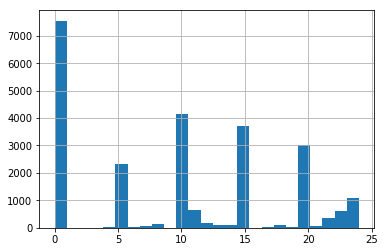

In [50]:
pd.Series(actions_chosen).hist(bins=25)

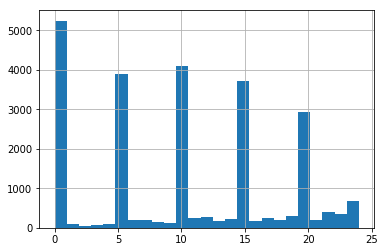

In [51]:
pd.Series(val_labels_asvec).hist(bins=25)